In [37]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import numpy as np
import torch
from community import community_louvain
from networkx.algorithms.community import girvan_newman
from itertools import islice
import random
import seaborn as sns
import re



# data_path="tripAdvisor/task2_graph.gml"
# parquet_path= "tripAdvisor/task2_df.parquet"

G = nx.read_gml('./task2_graph.gml')
df = pd.read_parquet('./task2_df.parquet')
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loaded DataFrame: {len(df)} rows")

print(G.number_of_nodes())

Loaded graph: 4846 nodes, 11238 edges
Loaded DataFrame: 5000 rows
4846


In [8]:
!pip install python-louvain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 5.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=e7c49dfeeaea8e06acd811ddc67aaaf3e82d3124f9394c148f970f601307b95b
  Stored in directory: /home/jovyan/.cache/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain

[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [34]:
df = pd.read_parquet('./task2_df.parquet')
print(df.columns)

Index(['restaurant_link', 'restaurant_name', 'original_location', 'country',
       'region', 'province', 'city', 'address', 'latitude', 'longitude',
       'claimed', 'awards', 'popularity_detailed', 'popularity_generic',
       'top_tags', 'price_level', 'price_range', 'meals', 'cuisines',
       'special_diets', 'features', 'vegetarian_friendly', 'vegan_options',
       'gluten_free', 'original_open_hours', 'open_days_per_week',
       'open_hours_per_week', 'working_shifts_per_week', 'avg_rating',
       'total_reviews_count', 'default_language',
       'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere',
       'keywords'],
      dtype='object')


In [35]:
print(df['popularity_generic'].isna().sum())
print(df['popularity_generic'])
# print(df['total_reviews_count'])

0
91460                      #1 of 3 places to eat in Suzette
701674         #277 of 458 places to eat in Reggio Calabria
389450            #6650 of 10645 places to eat in Barcelona
566304                                                 None
346212    #11 of 23 places to eat in Santa Lucia de Tira...
                                ...                        
604106                   #5 of 6 places to eat in Glynneath
489262                    #17 of 120 places to eat in Neath
772878                  #69 of 148 places to eat in Albenga
40406                 #6671 of 18480 places to eat in Paris
719098                 #3307 of 12913 places to eat in Rome
Name: popularity_generic, Length: 5000, dtype: object


In [17]:
# Step 1: Load required files
centrality_df = pd.read_csv('./task4_centrality.csv')
df = pd.read_parquet('./task2_df.parquet')
print(f"Loaded centrality data: {len(centrality_df)} rows")
print(f"Loaded restaurant data: {len(df)} rows")
print("Columns in restaurant data:", df.columns.tolist())

Loaded centrality data: 5000 rows
Loaded restaurant data: 5000 rows
Columns in restaurant data: ['restaurant_link', 'restaurant_name', 'original_location', 'country', 'region', 'province', 'city', 'address', 'latitude', 'longitude', 'claimed', 'awards', 'popularity_detailed', 'popularity_generic', 'top_tags', 'price_level', 'price_range', 'meals', 'cuisines', 'special_diets', 'features', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'original_open_hours', 'open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week', 'avg_rating', 'total_reviews_count', 'default_language', 'reviews_count_in_default_language', 'excellent', 'very_good', 'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere', 'keywords']


Common restaurant_names: 4838
Sample centrality restaurant_names: ['auberge de suzette', 'punto pizza pi snc', 'bracafe', 'the northern point', 'bar torres']
Sample restaurant dataset names: ['auberge de suzette', 'punto pizza pi snc', 'bracafe', 'the northern point', 'bar torres']

Sample popularity_generic and parsed popularity_score:
                                       popularity_generic  popularity_score
91460                    #1 of 3 places to eat in Suzette          1.000000
701674       #277 of 458 places to eat in Reggio Calabria          0.003610
389450          #6650 of 10645 places to eat in Barcelona          0.000150
566304                                               None               NaN
346212  #11 of 23 places to eat in Santa Lucia de Tira...          0.090909
222252               #492 of 8241 places to eat in Berlin          0.002033
813190            #5 of 6 places to eat in Persico Dosimo          0.200000
308569               #539 of 4650 places to eat in Vi

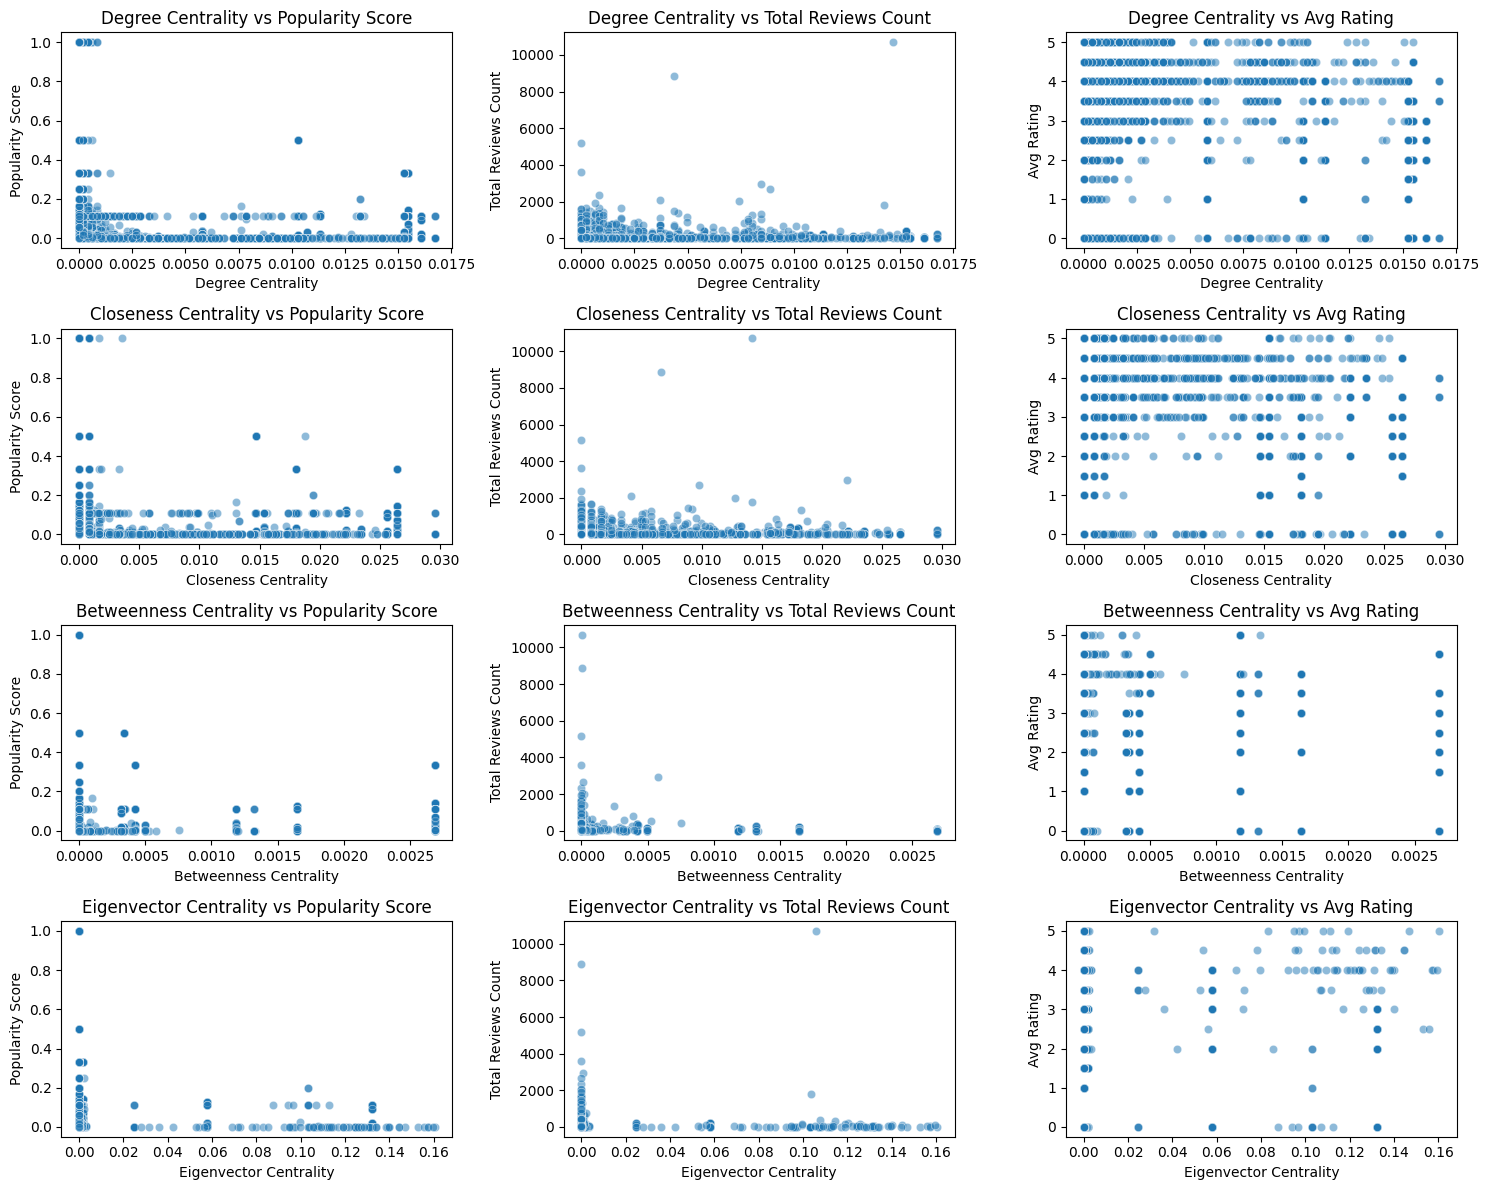

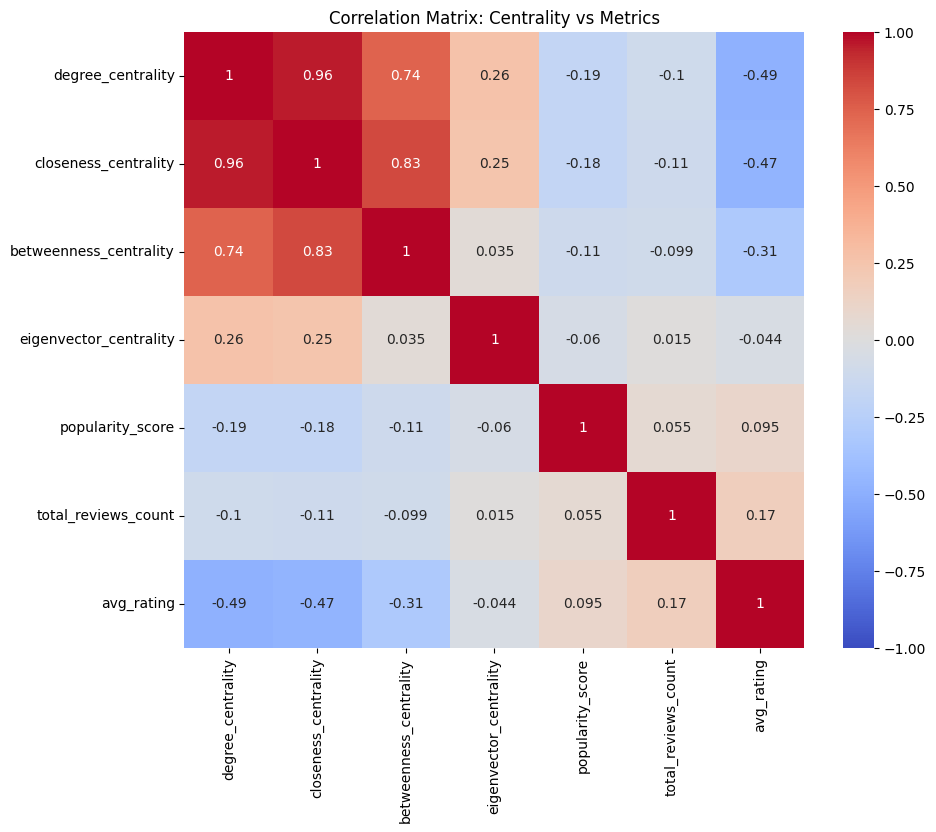

In [38]:
# Step 2: Clean restaurant_name for consistent merging
def clean_name(name):
    if pd.isna(name):
        return name
    # Strip spaces, lowercase, remove special characters, normalize spaces
    name = name.strip().lower()
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

centrality_df['restaurant_name'] = centrality_df['restaurant_name'].apply(clean_name)
df['restaurant_name'] = df['restaurant_name'].apply(clean_name)

# Verify common restaurant_names
common_names = len(set(centrality_df['restaurant_name']) & set(df['restaurant_name']))
print(f"Common restaurant_names: {common_names}")
print("Sample centrality restaurant_names:", centrality_df['restaurant_name'].head().tolist())
print("Sample restaurant dataset names:", df['restaurant_name'].head().tolist())

# Debug unmatched names
unmatched = set(centrality_df['restaurant_name']) - set(df['restaurant_name'])
if unmatched:
    print("Sample unmatched centrality names:", list(unmatched)[:5])

# Step 3: Parse popularity_generic into numeric popularity_score (1/rank)
def parse_popularity_generic(text):
    if pd.isna(text) or text is None or text.lower() == 'none':
        return np.nan
    # Extract ranking number (e.g., "#1" -> 1)
    match = re.search(r'#(\d+)', str(text))
    if match:
        rank = int(match.group(1))
        return 1.0 / rank if rank > 0 else np.nan  # Inverse rank for higher popularity = higher score
    return np.nan

df['popularity_score'] = df['popularity_generic'].apply(parse_popularity_generic)
print("\nSample popularity_generic and parsed popularity_score:")
print(df[['popularity_generic', 'popularity_score']].head(10))
print("popularity_score NaN count:", df['popularity_score'].isna().sum())

# Step 4: Identify available metrics
available_metrics = []
for col in ['popularity_score', 'total_reviews_count', 'avg_rating']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().sum() < len(df):
            available_metrics.append(col)
    else:
        print(f"Warning: Column {col} not found in task2_df.parquet")
if not available_metrics:
    raise ValueError("No valid metrics (popularity_score, total_reviews_count, avg_rating) found")

print(f"Available metrics: {available_metrics}")

# Step 5: Merge centrality scores with metrics
analysis_df = centrality_df[['restaurant_name', 'degree_centrality', 'closeness_centrality', 
                            'betweenness_centrality', 'eigenvector_centrality']].merge(
    df[['restaurant_name'] + available_metrics],
    on='restaurant_name',
    how='left'
)
print(f"Merged data: {len(analysis_df)} rows")

# Step 6: Handle missing or invalid data
numeric_columns = ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 
                   'eigenvector_centrality'] + available_metrics
for col in numeric_columns:
    analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Check NaN values
print("\nNaN counts in numeric columns:")
print(analysis_df[numeric_columns].isna().sum())

# Impute NaN for metrics
for col in available_metrics:
    if col in ['total_reviews_count']:
        analysis_df[col] = analysis_df[col].fillna(0)
    else:  # popularity_score, avg_rating
        analysis_df[col] = analysis_df[col].fillna(analysis_df[col].mean())

# Drop rows where all centrality scores are NaN
analysis_df = analysis_df.dropna(subset=['degree_centrality', 'eigenvector_centrality'], how='all')
print(f"Data after cleaning: {len(analysis_df)} rows")

# Step 7: Compute Pearson correlations
correlation_matrix = analysis_df[numeric_columns].corr(method='pearson')
print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Extract relevant correlations
correlations = correlation_matrix.loc[
    ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality'],
    available_metrics
]
print("\nCentrality vs. Metrics Correlations:")
print(correlations)

# Step 8: Interpret results
print("\nInterpretations and Implications:")
print("Note: popularity_generic was parsed into popularity_score (1/rank, higher score = higher popularity).")
for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    print(f"\n{centrality.replace('_', ' ').title()}:")
    for metric in available_metrics:
        corr = correlations.loc[centrality, metric]
        strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"- Correlation with {metric}: {corr:.4f} ({strength}, {direction})")
        print(f"  Implication: {centrality.replace('_', ' ').title()} {'is' if abs(corr) > 0.3 else 'is not'} strongly linked to {metric}.")

# Step 9: Visualize relationships (Scatter Plots)
n_metrics = len(available_metrics)
plt.figure(figsize=(15, 4 * n_metrics))
plot_idx = 1
for centrality in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    for metric in available_metrics:
        plt.subplot(4, n_metrics, plot_idx)
        sns.scatterplot(data=analysis_df, x=centrality, y=metric, alpha=0.5)
        plt.title(f"{centrality.replace('_', ' ').title()} vs {metric.replace('_', ' ').title()}")
        plt.xlabel(centrality.replace('_', ' ').title())
        plt.ylabel(metric.replace('_', ' ').title())
        plot_idx += 1
plt.tight_layout()
plt.savefig('./task5_scatter_plots.png')
print("Scatter plots saved to /task5_scatter_plots.png")

# Step 10: Visualize correlation matrix (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix: Centrality vs Metrics')
plt.savefig('./task5_heatmap.png')
print("Correlation heatmap saved to /task5_heatmap.png")

# Step 11: Save results
correlations.to_csv('./task5_correlations.csv')
analysis_df.to_csv('./task5_analysis.csv', index=False)
print("Saved correlations to /task5_correlations.csv and analysis to /task5_analysis.csv")